In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import FactorAnalysis
import glob
from sncosmo.salt2utils import BicubicInterpolator
from matplotlib.ticker import ScalarFormatter, FuncFormatter
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split
import sncosmo
from scipy.interpolate import interp1d
from numpy import random
import pickle as pk
from astropy.table import Table
from sncosmo.constants import HC_ERG_AA
from sklearn import preprocessing

SCALE_FACTOR = 1e-12

sns.set_style("whitegrid", {'axes.grid':'False','xtick.bottom': True,'ytick.left': True})

params = {"text.usetex" : True,'font.size': 20, 'font.family':'serif', 'font.serif':'Computer Modern'}
plt.rcParams.update(params)

In [2]:
# The FA class from sklearn return the common factors centered around mean and with variance unit.
# However, comparing each rotation with or with out previous scaling shows different common factor.
# The difference is more clear for varimax and quartimax. In the absence of rotation the versions
# with and without previous scaling are indistinguisable.

# So we can conclude FA from sklearn does not scale the data before applying its algorithm.

In [3]:
class ScalarFormatterClass1(ScalarFormatter):
    def _set_format(self):
        self.format = "%1.1f"

In [4]:
p_grid=np.arange(-10,51,1)
w_grid1=np.arange(3350,8710,10)
w_grid2=np.arange(3400,8410,10)

In [5]:
fname=[]
for file in glob.glob("./final_SEDs/*.dat"):
    fname.append(file.split("/")[2].split(".")[0])

In [6]:
exclude=["Train_SN93_SED","Test_SN15_SED","Test_SN26_SED","Train_SN30_SED","Train_SN96_SED"]

In [7]:
data=[]
sne_names=[]
for sn in fname:
    if sn not in exclude:
        data.append(pd.read_csv(f"./final_SEDs/{sn}.dat")["flux"].values)
        sne_names.append(sn)

In [8]:
len(data)

164

## Applying FA

In [9]:
train_data, test_data, train_names, test_names=train_test_split(data,sne_names,test_size=0.1,random_state=0)

### FA sklearn

In [10]:
Means=np.mean(train_data,axis=1)

In [11]:
len(Means)

147

In [12]:
mean_cor_data=[train_data[i]-Means[i] for i in range(len(train_data))]

In [13]:
training_data=np.array(mean_cor_data).T

In [14]:
fa3_no_rot = FactorAnalysis(3,rotation=None)
fa3_quartimax = FactorAnalysis(3,rotation="quartimax")
fa3_varimax = FactorAnalysis(3,rotation="varimax")

In [15]:
factors_no_rot=fa3_no_rot.fit_transform(training_data)
factors_quartimax=fa3_quartimax.fit_transform(training_data)
factors_varimax=fa3_varimax.fit_transform(training_data)

In [16]:
fa3_no_rot.noise_variance_

array([2.64435603e-05, 3.46937574e-05, 3.06820005e-04, 1.06926409e-04,
       8.80566119e-05, 3.82558658e-05, 5.39889709e-05, 3.10737761e-05,
       1.95037545e-05, 2.47653966e-05, 4.33488327e-05, 1.00063103e-04,
       5.32865725e-05, 2.65918862e-04, 1.16384468e-04, 3.44979852e-04,
       4.13057273e-05, 1.25975664e-05, 2.30827061e-04, 3.44492867e-05,
       4.90714603e-05, 1.70787250e-04, 3.22765593e-05, 3.10752949e-05,
       6.07269995e-05, 9.40935527e-05, 2.33732549e-05, 4.62419208e-04,
       4.02342986e-05, 5.62928267e-05, 3.59691520e-05, 2.97348156e-05,
       1.05118869e-04, 6.64808784e-05, 2.01574118e-05, 1.00734323e-04,
       2.82608399e-05, 1.05145145e-04, 4.07667033e-05, 7.17588497e-05,
       2.19370560e-04, 6.13300189e-05, 6.47986215e-05, 3.62351354e-05,
       1.36524732e-05, 1.21692608e-04, 2.58853481e-05, 2.24580484e-04,
       2.22255592e-05, 4.56609867e-05, 1.12032842e-05, 7.20807167e-05,
       2.63637470e-05, 6.18726892e-05, 1.60745902e-04, 1.00916785e-04,
      

In [16]:
factors_no_rot.shape

(30561, 3)

In [17]:
fa3_no_rot.components_.shape

(3, 147)

In [16]:
# Even if the initial data is not scaled, neither by centering nor variance scaled, the
# common factor returned have zero mean and unit variance

In [17]:
np.mean(train_data[0])

0.06598197666597747

In [18]:
np.std(train_data[0])

0.0707685317487314

In [19]:
for i in range(3):
    print(np.mean(factors_no_rot[:,i]))
    print(np.mean(factors_quartimax[:,i]))
    print(np.mean(factors_varimax[:,i]))

0.0
0.0
0.0
-4.4639967692791217e-17
1.4879989230930407e-17
-1.1159991923197803e-16
2.9759978461860813e-17
0.0
1.4879989230930407e-17


In [20]:
for i in range(3):
    print(np.std(factors_no_rot[:,i]))
    print(np.std(factors_quartimax[:,i]))
    print(np.std(factors_varimax[:,i]))

0.9999572248200617
0.999921837366577
0.9998590416641405
0.9962985853161564
0.995322911836446
0.994855546846047
0.9933038284805887
0.9943170714504882
0.9948478054250919


In [18]:
fa_loadings_no_rot = fa3_no_rot.components_.T
fa_loadings_quartimax = fa3_quartimax.components_.T
fa_loadings_varimax = fa3_varimax.components_.T

total_var = np.sum(np.var(training_data,axis=0))

In [22]:
var_exp_no_rot = np.sum(fa_loadings_no_rot**2, axis=0)
var_exp_quartimax = np.sum(fa_loadings_quartimax**2, axis=0)
var_exp_varimax = np.sum(fa_loadings_varimax**2, axis=0)

prop_var_exp_no_rot = var_exp_no_rot/total_var
prop_var_exp_quartimax = var_exp_quartimax/total_var
prop_var_exp_varimax = var_exp_varimax/total_var

cum_prop_var_exp_no_rot = np.cumsum(var_exp_no_rot/total_var)
cum_prop_var_exp_quartimax = np.cumsum(var_exp_quartimax/total_var)
cum_prop_var_exp_varimax = np.cumsum(var_exp_varimax/total_var)

In [23]:
Mean_transformed_no_rot=fa3_no_rot.transform(Means.reshape(1, -1))
Mean_transformed_quartimax=fa3_quartimax.transform(Means.reshape(1, -1))
Mean_transformed_varimax=fa3_varimax.transform(Means.reshape(1, -1))

In [24]:
Means.reshape(1, -1)

array([[0.06598198, 0.07636915, 0.07131505, 0.04515383, 0.08801059,
        0.05892789, 0.05867979, 0.04139114, 0.0464325 , 0.05467567,
        0.05759686, 0.07069625, 0.04927618, 0.05584468, 0.07336066,
        0.11721421, 0.03133133, 0.05543782, 0.03608717, 0.05275541,
        0.05731496, 0.04325832, 0.01567472, 0.07472185, 0.07017104,
        0.04427059, 0.06060524, 0.10402757, 0.04821589, 0.06854006,
        0.04700676, 0.01501117, 0.09669967, 0.04562504, 0.05280698,
        0.04384909, 0.07162469, 0.05983604, 0.05326231, 0.0448599 ,
        0.10085401, 0.07062957, 0.06521558, 0.05956035, 0.02409036,
        0.09941132, 0.05997178, 0.07893686, 0.06580641, 0.05399306,
        0.00539823, 0.04995551, 0.03975734, 0.07835266, 0.03324708,
        0.09244754, 0.04271457, 0.06399298, 0.08230851, 0.07521016,
        0.08934015, 0.07230314, 0.05615916, 0.08942605, 0.05196059,
        0.04940476, 0.07151643, 0.08916993, 0.03893819, 0.08537601,
        0.06633911, 0.04267671, 0.04392233, 0.06

In [30]:
np.dot(Means,fa3_no_rot.components_[0]) # Não é simplesmente projetar em cada nova componente da base, como é para o PCA

0.6888244123002416

In [26]:
fa3_no_rot.transform(Means.reshape(1, -1))

array([[ 0.93008705, -0.38011209, -0.08891455]])

In [27]:
Mean_transformed_no_rot

array([[ 0.93008705, -0.38011209, -0.08891455]])

In [25]:
# The cumulative explained variances varies a little, comparing the two sklearn versions,
# with and without scaling. The non scaled version have every score a litlle higher.

In [26]:
# The biggest difference is regarding varimax rotation, that for the scaled version have
# cumulative proportion of variance [0.568 0.846 0.968]

In [27]:
print(f"variance explained no rot: {var_exp_no_rot.round(2)}")
print(f"proportion of variance explained no rot: {prop_var_exp_no_rot.round(3)}")
print(f"cumulative proportion of variance explained no rot: {cum_prop_var_exp_no_rot.round(3)}")

variance explained no rot: [0.74 0.01 0.  ]
proportion of variance explained no rot: [0.961 0.012 0.006]
cumulative proportion of variance explained no rot: [0.961 0.973 0.979]


In [28]:
print(f"variance explained quartimax: {var_exp_quartimax.round(2)}")
print(f"proportion of variance explained quartimax: {prop_var_exp_quartimax.round(3)}")
print(f"cumulative proportion of variance explained quartimax: {cum_prop_var_exp_quartimax.round(3)}")

variance explained quartimax: [0.73 0.01 0.01]
proportion of variance explained quartimax: [0.959 0.014 0.007]
cumulative proportion of variance explained quartimax: [0.959 0.972 0.979]


In [29]:
print(f"variance explained no rot varimax: {var_exp_varimax.round(2)}")
print(f"proportion of variance explained no rot varimax: {prop_var_exp_varimax.round(3)}")
print(f"cumulative proportion of variance explained no rot varimax: {cum_prop_var_exp_varimax.round(3)}")

variance explained no rot varimax: [0.73 0.02 0.01]
proportion of variance explained no rot varimax: [0.948 0.022 0.009]
cumulative proportion of variance explained no rot varimax: [0.948 0.97  0.979]


In [30]:
# The explained variances are exactly the same if we
# just center the data. Indicating this process is done
# internally anyway.

In [31]:
X, Y=np.meshgrid(p_grid,w_grid2)

In [32]:
M_3_no_rot=[]
for i in range(3):
    sup_no_rot=factors_no_rot[::,i]+Mean_transformed_no_rot[0][i]
    M_3_no_rot.append(sup_no_rot.reshape(X.shape))

In [33]:
M_3_quartimax=[]
for i in range(3):
    sup_quartimax=factors_quartimax[::,i]+Mean_transformed_quartimax[0][i]
    M_3_quartimax.append(sup_quartimax.reshape(X.shape))

In [34]:
M_3_varimax=[]
for i in range(3):
    sup_varimax=factors_varimax[::,i]+Mean_transformed_varimax[0][i]
    M_3_varimax.append(sup_varimax.reshape(X.shape))

In [35]:
np.savetxt("./fa/sk_no_rot_M0.txt",M_3_no_rot[0])
np.savetxt("./fa/sk_no_rot_M1.txt",M_3_no_rot[1])
np.savetxt("./fa/sk_no_rot_M2.txt",M_3_no_rot[2])

In [36]:
np.savetxt("./fa/sk_quartimax_M0.txt",M_3_quartimax[0])
np.savetxt("./fa/sk_quartimax_M1.txt",M_3_quartimax[1])
np.savetxt("./fa/sk_quartimax_M2.txt",M_3_quartimax[2])

In [37]:
np.savetxt("./fa/sk_varimax_M0.txt",M_3_varimax[0])
np.savetxt("./fa/sk_varimax_M1.txt",M_3_varimax[1])
np.savetxt("./fa/sk_varimax_M2.txt",M_3_varimax[2])

### Plots 3d

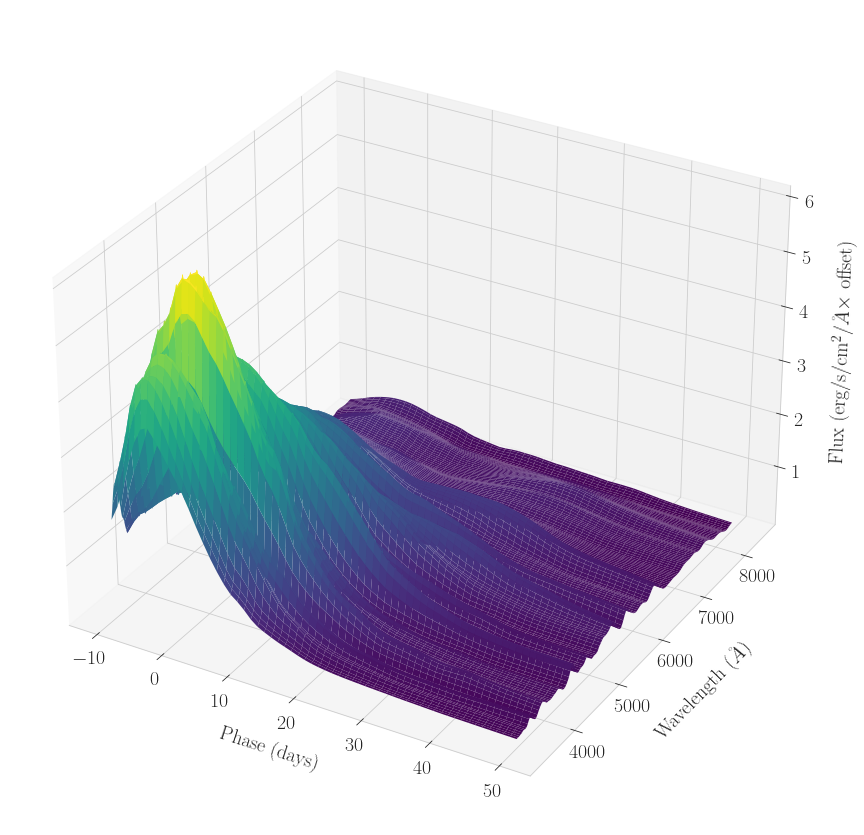

In [38]:
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,M_3_no_rot[0],cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel(r"Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.set_zlabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
ax.zaxis.labelpad=15
fig.tight_layout()
plt.savefig('./fa/sk_M0_no_rot.pdf')  

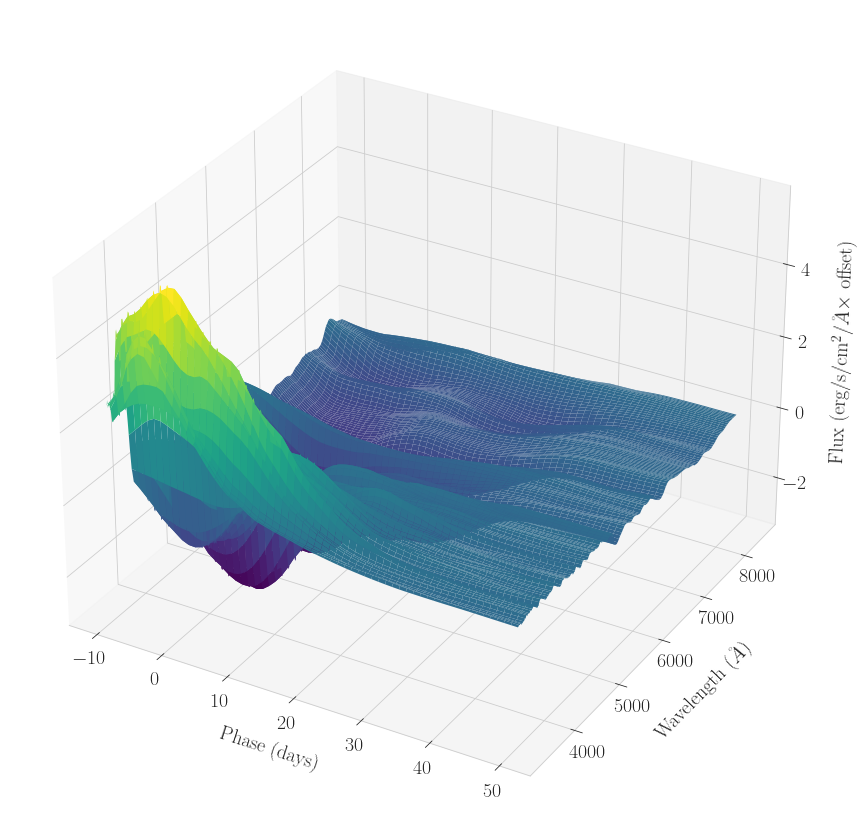

In [39]:
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,M_3_no_rot[1],cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel(r"Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.set_zlabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
ax.zaxis.labelpad=15
fig.tight_layout()
plt.savefig('./fa/sk_M1_no_rot.pdf')  

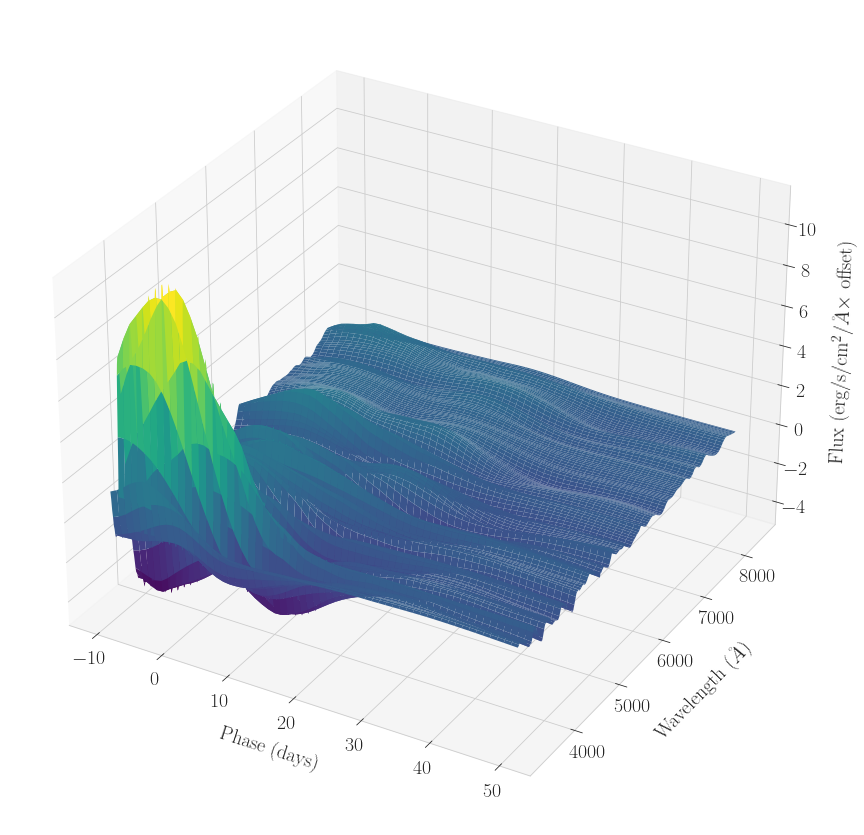

In [40]:
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,M_3_no_rot[2],cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel(r"Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.set_zlabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
ax.zaxis.labelpad=15
fig.tight_layout()
plt.savefig('./fa/sk_M2_no_rot.pdf')  

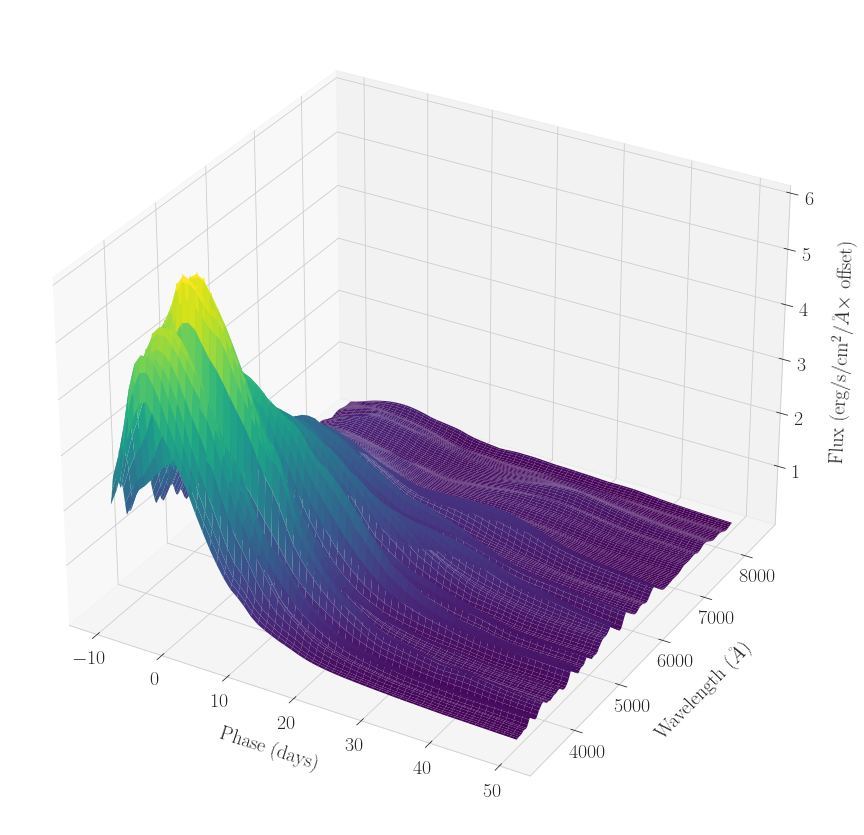

In [41]:
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,M_3_quartimax[0],cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel(r"Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.set_zlabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
ax.zaxis.labelpad=15
fig.tight_layout()
plt.savefig('./fa/sk_M0_quartimax.pdf')  

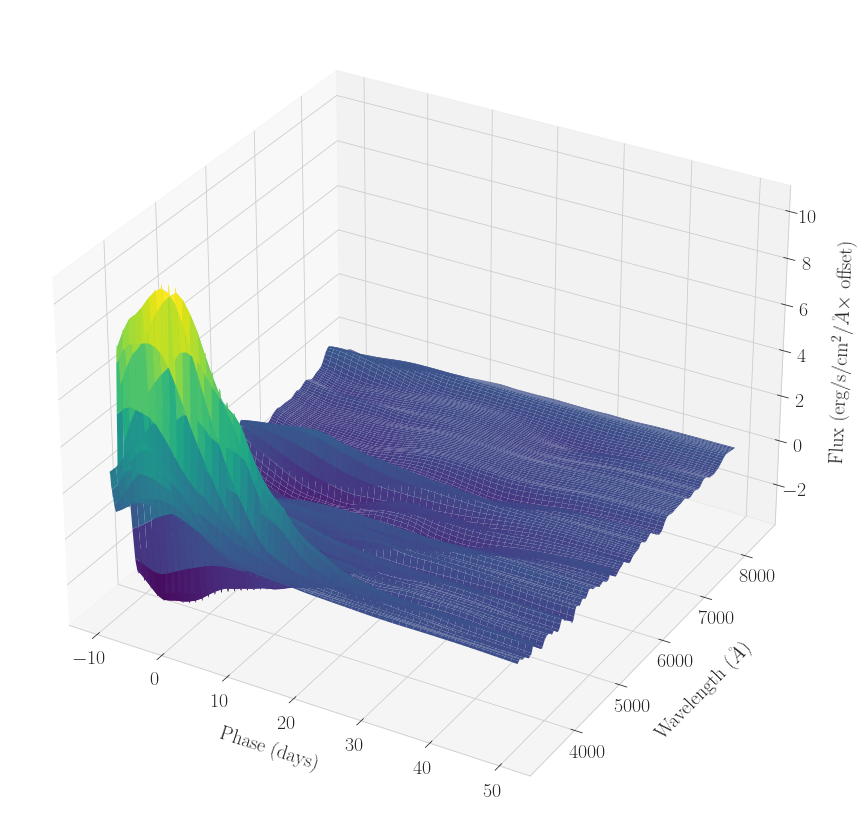

In [42]:
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,M_3_quartimax[1],cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel(r"Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.set_zlabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
ax.zaxis.labelpad=15
fig.tight_layout()
plt.savefig('./fa/sk_M1_quartimax.pdf')  

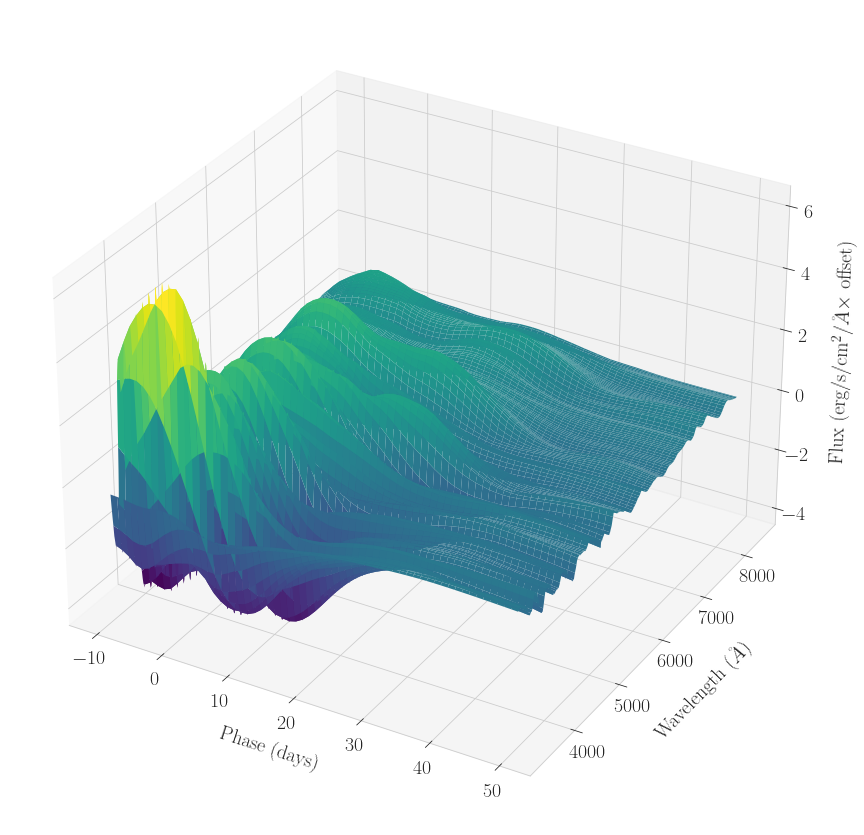

In [43]:
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,M_3_quartimax[2],cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel(r"Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.set_zlabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
ax.zaxis.labelpad=15
fig.tight_layout()
plt.savefig('./fa/sk_M2_quartimax.pdf')  

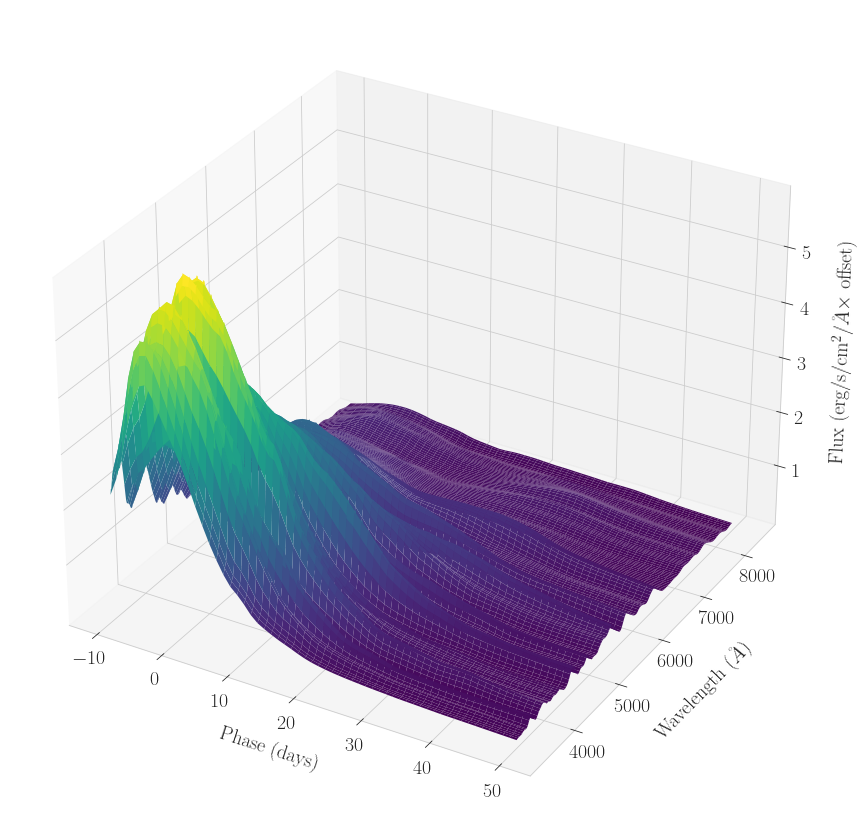

In [44]:
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,M_3_varimax[0],cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel(r"Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.set_zlabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
ax.zaxis.labelpad=15
fig.tight_layout()
plt.savefig('./fa/sk_M0_varimax.pdf')  

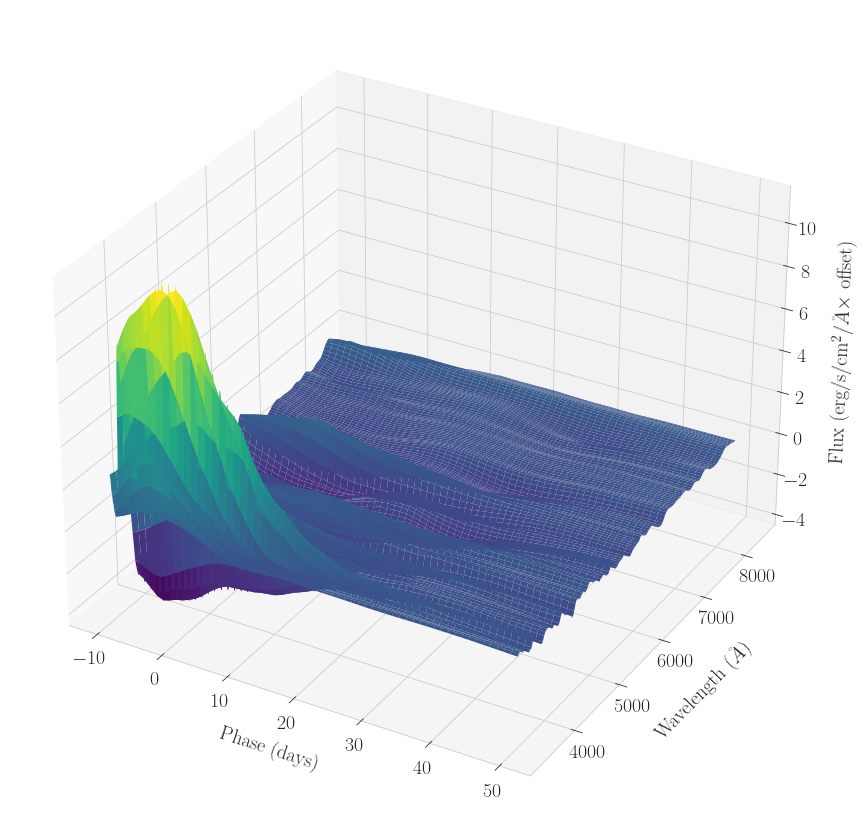

In [45]:
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,M_3_varimax[1],cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel(r"Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.set_zlabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
ax.zaxis.labelpad=15
fig.tight_layout()
plt.savefig('./fa/sk_M1_varimax.pdf')  

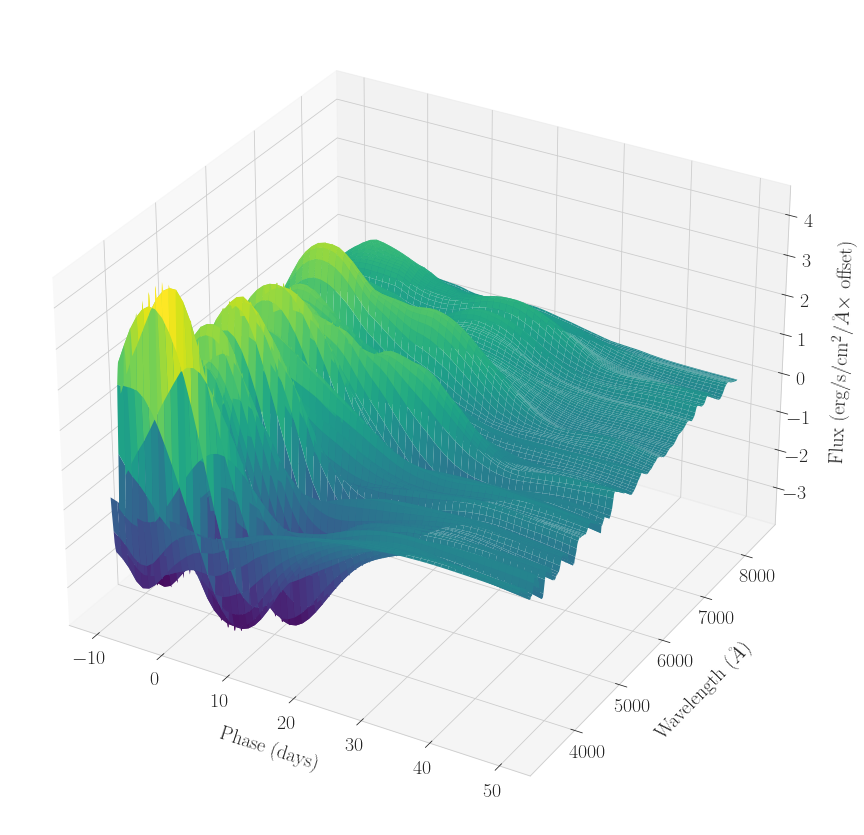

In [46]:
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,M_3_varimax[2],cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel(r"Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.set_zlabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
ax.zaxis.labelpad=15
fig.tight_layout()
plt.savefig('./fa/sk_M2_varimax.pdf')  

In [47]:
# Each and every surface looks the same when centering or not
# the data. This reinforces the idea this centering would
# be anyway performed internally.

### Sectional plots

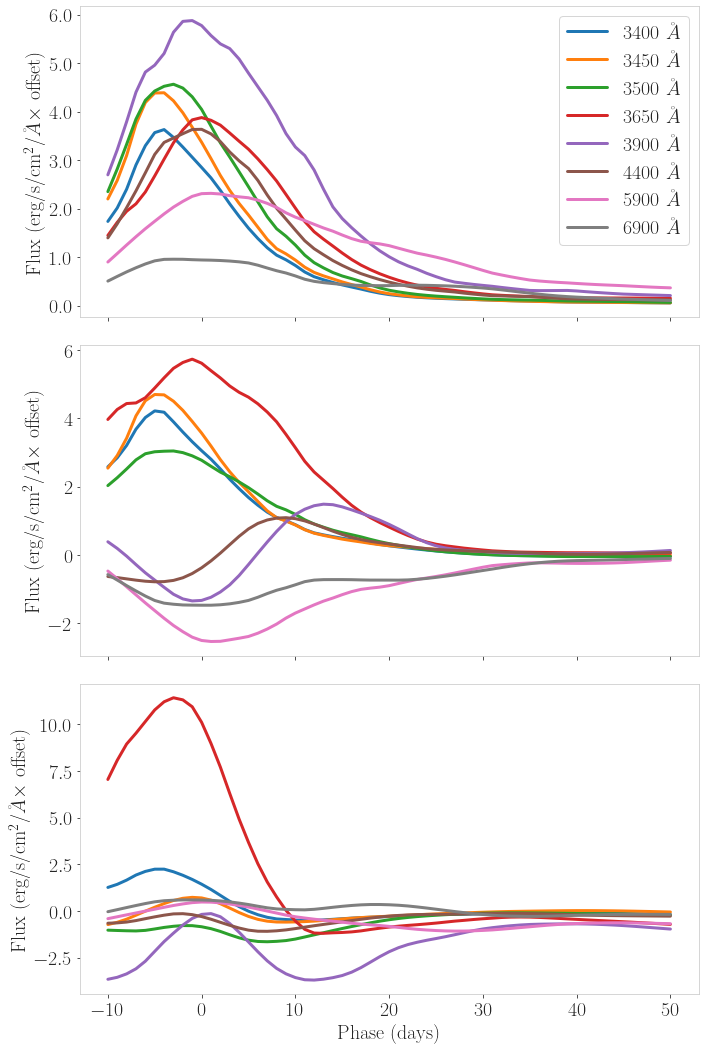

In [48]:
fig, axs = plt.subplots(3,1,figsize=(10,15),sharex=True)
#fig.subplots_adjust(hspace=0.)

colors=["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b","#e377c2","#7f7f7f"]#"#fde725","#a0da39","#4ac16d","#1fa187","#277f8e","#365c8d","#46327e","#440154"]
for j,i in enumerate([0,5,10,25,50,100,250,350]):#
    axs[0].plot(X[i],M_3_no_rot[0][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    #ax1.set_xlabel("Phase (days)")
    axs[0].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax1.set_title("First Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[0].yaxis.set_major_formatter(formatter11)
    axs[0].legend()
for j,i in enumerate([0,5,10,25,50,100,250,350]):
    axs[1].plot(X[i],M_3_no_rot[1][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    #ax2.set_xlabel("Phase (days)")
    axs[1].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax2.set_title("Second Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    #axs[1].yaxis.set_major_formatter(formatter11)
    #axs[1].legend(loc=1)
for j,i in enumerate([0,5,10,25,50,100,250,350]):
    axs[2].plot(X[i],M_3_no_rot[2][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    axs[2].set_xlabel("Phase (days)")
    axs[2].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax3.set_title("Third Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    #axs[2].yaxis.set_major_formatter(formatter11)
    #axs[2].legend(loc=1)

#plt.show()
fig.tight_layout()
plt.savefig('./fa/sk_FA_components_no_rot.pdf')  

# First, Second and Third Principal Components

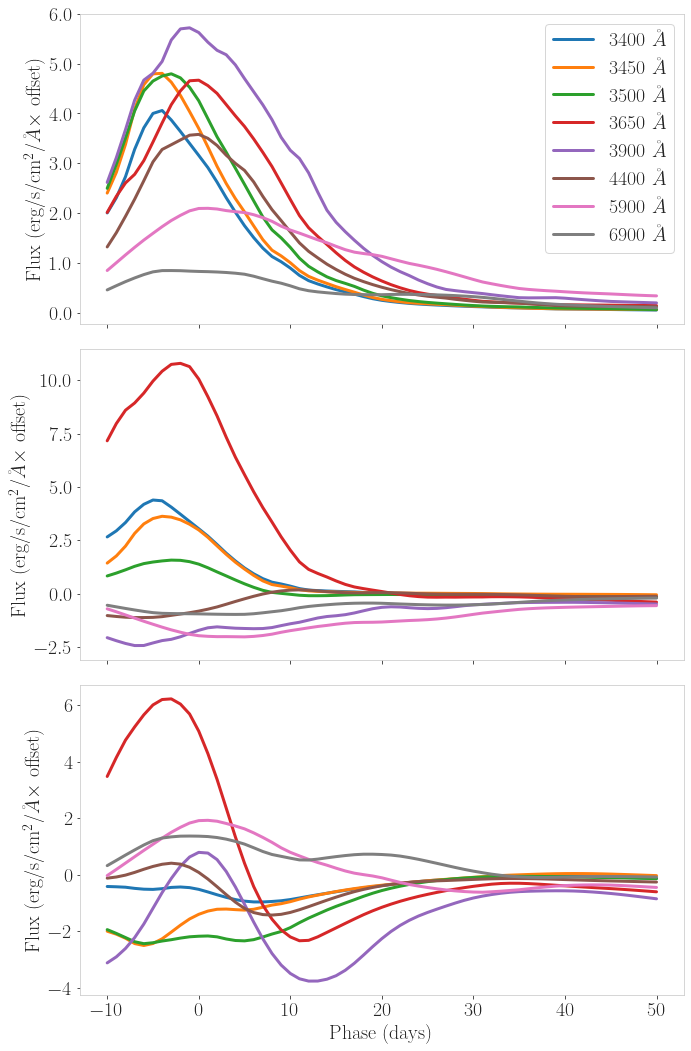

In [49]:
fig, axs = plt.subplots(3,1,figsize=(10,15),sharex=True)
#fig.subplots_adjust(hspace=0.)

colors=["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b","#e377c2","#7f7f7f"]#"#fde725","#a0da39","#4ac16d","#1fa187","#277f8e","#365c8d","#46327e","#440154"]
for j,i in enumerate([0,5,10,25,50,100,250,350]):#
    axs[0].plot(X[i],M_3_quartimax[0][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    #ax1.set_xlabel("Phase (days)")
    axs[0].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax1.set_title("First Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[0].yaxis.set_major_formatter(formatter11)
    axs[0].legend()
for j,i in enumerate([0,5,10,25,50,100,250,350]):
    axs[1].plot(X[i],M_3_quartimax[1][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    #ax2.set_xlabel("Phase (days)")
    axs[1].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax2.set_title("Second Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    #axs[1].yaxis.set_major_formatter(formatter11)
    #axs[1].legend(loc=1)
for j,i in enumerate([0,5,10,25,50,100,250,350]):
    axs[2].plot(X[i],M_3_quartimax[2][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    axs[2].set_xlabel("Phase (days)")
    axs[2].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax3.set_title("Third Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    #axs[2].yaxis.set_major_formatter(formatter11)
    #axs[2].legend(loc=1)

#plt.show()
fig.tight_layout()
plt.savefig('./fa/sk_FA_components_quartimax.pdf')  

# First, Second and Third Principal Components

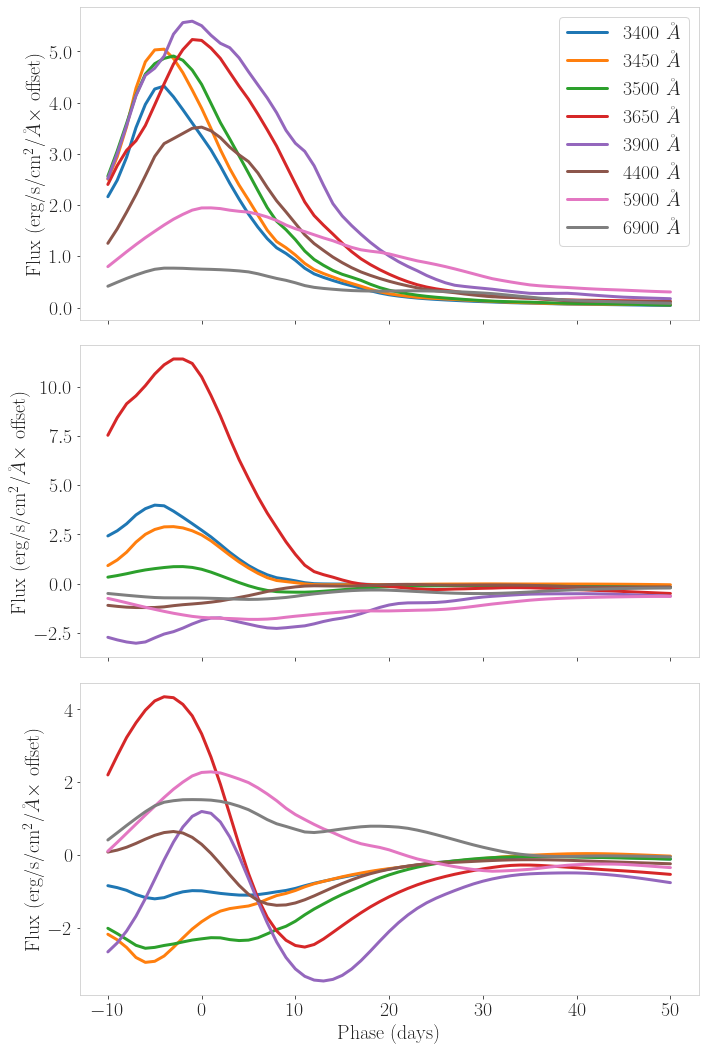

In [50]:
fig, axs = plt.subplots(3,1,figsize=(10,15),sharex=True)
#fig.subplots_adjust(hspace=0.)

colors=["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b","#e377c2","#7f7f7f"]#"#fde725","#a0da39","#4ac16d","#1fa187","#277f8e","#365c8d","#46327e","#440154"]
for j,i in enumerate([0,5,10,25,50,100,250,350]):#
    axs[0].plot(X[i],M_3_varimax[0][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    #ax1.set_xlabel("Phase (days)")
    axs[0].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax1.set_title("First Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[0].yaxis.set_major_formatter(formatter11)
    axs[0].legend()
for j,i in enumerate([0,5,10,25,50,100,250,350]):
    axs[1].plot(X[i],M_3_varimax[1][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    #ax2.set_xlabel("Phase (days)")
    axs[1].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax2.set_title("Second Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    #axs[1].yaxis.set_major_formatter(formatter11)
    #axs[1].legend(loc=1)
for j,i in enumerate([0,5,10,25,50,100,250,350]):
    axs[2].plot(X[i],M_3_varimax[2][i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    axs[2].set_xlabel("Phase (days)")
    axs[2].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax3.set_title("Third Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    #axs[2].yaxis.set_major_formatter(formatter11)
    #axs[2].legend(loc=1)

#plt.show()
fig.tight_layout()
plt.savefig('./fa/sk_FA_components_varimax.pdf')  

# First, Second and Third Principal Components

## Creating synthetic photometry from test data

In [51]:
filters=["cspg","cspr","cspv9844"]

In [52]:
filters_label=["CSP-G","CSP-R","CSP-V9844"]

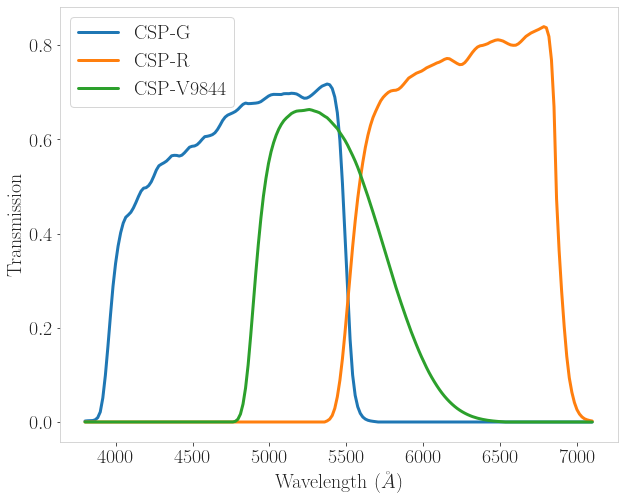

In [53]:
fig=plt.figure(figsize=(10,8))
colors=["#1f77b4","#ff7f0e","#2ca02c"]#"#fde725","#21918c","#440154"]
for j,f in enumerate(filters):
    plt.plot(np.linspace(3800,7100,200),sncosmo.get_bandpass(f)(np.linspace(3800,7100,200)),label=filters_label[j],lw=3,color=colors[j])
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("Transmission")
plt.legend(loc=2)
plt.show()

In [54]:
d={}
for i in range(len(test_data)):
    d[i]=test_data[i].reshape(Y.shape)*SCALE_FACTOR

## Validating the FA

In [55]:
M_3_no_rot[0].shape

(501, 61)

In [56]:
class EXP_LC_FA3(sncosmo.Source):
    
    _param_names = ['x0', 'x1', 'x2']
    param_names_latex = ['x_0', 'x_1', 'x_2']
    
    
    def __init__(self, phase, wave, flux0, flux1, flux2, name='EXP', version='2022'):

        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        
        self._model_flux0  = BicubicInterpolator(phase, wave, flux0.T) # originalmente o fluxo esta no formato (501,61)
        self._model_flux1  = BicubicInterpolator(phase, wave, flux1.T)
        self._model_flux2  = BicubicInterpolator(phase, wave, flux2.T)

        self._parameters = np.array([1, 0, 0])  # initial guess
        

    def _flux(self, phase, wave):
        
        x0, x1, x2= self._parameters

        return x0 * (self._model_flux0(phase, wave) +  x1 * self._model_flux1(phase, wave) +  x2 * self._model_flux2(phase, wave))

In [57]:
exp_fa3_no_rot = EXP_LC_FA3(p_grid, w_grid2, M_3_no_rot[0]*SCALE_FACTOR, M_3_no_rot[1]*SCALE_FACTOR, M_3_no_rot[2]*SCALE_FACTOR)
exp_fa3_quartimax = EXP_LC_FA3(p_grid, w_grid2, M_3_quartimax[0]*SCALE_FACTOR, M_3_quartimax[1]*SCALE_FACTOR, M_3_quartimax[2]*SCALE_FACTOR)
exp_fa3_varimax = EXP_LC_FA3(p_grid, w_grid2, M_3_varimax[0]*SCALE_FACTOR, M_3_varimax[1]*SCALE_FACTOR, M_3_varimax[2]*SCALE_FACTOR)

In [58]:
csp=sncosmo.get_magsystem("csp")

In [59]:
file=open("./fa/sk_validation_fit_results.dat","w")

In [60]:
for k in range(len(d)):
    print(test_names[k])
    fig,axs=plt.subplots(3,1,figsize=(8,12),sharex=True)
    #fig.subplots_adjust(hspace=0.1)
    colors=["#1f77b4","#ff7f0e","#2ca02c"]#"#fde725","#21918c","#440154"]
    filt=[]
    ph=[]
    fl=[]
    flerr=[]
    for j,f in enumerate(filters):
        lc=interp1d(p_grid,np.sum(d[k]*sncosmo.get_bandpass(f)(Y)*Y*10/HC_ERG_AA,axis=0))
        np.random.seed(42)
        p_random=np.random.choice(np.linspace(-10,50,61), size=15, replace=False)
        #p_random.sort()
        np.random.seed(42)
        y_err=lc(p_random)*np.array([random.rand() for i in range(15)])/10

        filt.append([f]*len(p_random))
        ph.append(list(p_random))
        fl.append(list(lc(p_random)))
        flerr.append(list(y_err))
        #axs[j].errorbar(p_random,lc(p_random),yerr=y_err,label=f"Flux through {f} filter",color=colors[j],ls="none",fmt='o')

    df={"time":np.array(ph).reshape(-1),"flux":np.array(fl).reshape(-1),"fluxerr":np.array(flerr).reshape(-1),"flt":np.array(filt).reshape(-1)}
    df=pd.DataFrame(df)
    df["zpsys"]="csp"
    
    zp=[]
    for j in df["flt"]:
        zp.append(2.5*np.log10(csp.zpbandflux(j)))

    df["zp"]=zp

    dust = sncosmo.F99Dust()
    model_fa3_no_rot = sncosmo.Model(source=exp_fa3_no_rot)
    model_fa3_no_rot.set(z=0.,t0=0.) 
    model_fa3_quartimax = sncosmo.Model(source=exp_fa3_quartimax)
    model_fa3_quartimax.set(z=0.,t0=0.) 
    model_fa3_varimax = sncosmo.Model(source=exp_fa3_varimax)
    model_fa3_varimax.set(z=0.,t0=0.) 
    
    dat=Table.from_pandas(df)
    dat.remove_rows(np.where(dat["flux"]<0.))
    dat.remove_rows(np.where(dat["fluxerr"]<0.))

    result_fa3_no_rot, fitted_model_fa3_no_rot = sncosmo.fit_lc(dat, model_fa3_no_rot, ['x0', 'x1', 'x2'],modelcov=False, phase_range=(-10, 50.), wave_range=(3500.,8400.), verbose=False)
    result_fa3_quartimax, fitted_model_fa3_quartimax = sncosmo.fit_lc(dat, model_fa3_quartimax, ['x0', 'x1', 'x2'],modelcov=False, phase_range=(-10, 50.), wave_range=(3500.,8400.), verbose=False)
    result_fa3_varimax, fitted_model_fa3_varimax = sncosmo.fit_lc(dat, model_fa3_varimax, ['x0', 'x1', 'x2'],modelcov=False, phase_range=(-10, 50.), wave_range=(3500.,8400.), verbose=False)
    
    file.write(f"{test_names[k]}:\n")
    file.write(f"EXP3(FA) no rot fit chi2/ndof={round(result_fa3_no_rot.chisq/result_fa3_no_rot.ndof,2)}\n")
    file.write(f"x0={round(result_fa3_no_rot.parameters[2],4)} +/- {round(result_fa3_no_rot.errors['x0'],4)}, x1={round(result_fa3_no_rot.parameters[3],4)} +/- {round(result_fa3_no_rot.errors['x1'],4)}, x2={round(result_fa3_no_rot.parameters[4],4)} +/- {round(result_fa3_no_rot.errors['x2'],4)}\n")
    file.write(f"EXP3(FA) quartimax fit chi2/ndof={round(result_fa3_quartimax.chisq/result_fa3_quartimax.ndof,2)}\n")
    file.write(f"x0={round(result_fa3_quartimax.parameters[2],4)} +/- {round(result_fa3_quartimax.errors['x0'],4)}, x1={round(result_fa3_quartimax.parameters[3],4)} +/- {round(result_fa3_quartimax.errors['x1'],4)}, x2={round(result_fa3_quartimax.parameters[4],4)} +/- {round(result_fa3_quartimax.errors['x2'],4)}\n")
    file.write(f"EXP3(FA) varimax fit chi2/ndof={round(result_fa3_varimax.chisq/result_fa3_varimax.ndof,2)}\n")
    file.write(f"x0={round(result_fa3_varimax.parameters[2],4)} +/- {round(result_fa3_varimax.errors['x0'],4)}, x1={round(result_fa3_varimax.parameters[3],4)} +/- {round(result_fa3_varimax.errors['x1'],4)}, x2={round(result_fa3_varimax.parameters[4],4)} +/- {round(result_fa3_varimax.errors['x2'],4)}\n\n")
    
        
    for j,f in enumerate(filters):
        axs[j].errorbar(dat[dat["flt"]==f]["time"], dat[dat["flt"]==f]["flux"]*10**(-0.4*dat[dat["flt"]==f]["zp"]+11), yerr=dat[dat["flt"]==f]["fluxerr"]*10**(-0.4*dat[dat["flt"]==f]["zp"]+11),label=f"Synthetic photometry in {filters_label[j]}",color=colors[j],ls="none",fmt='o')
        axs[j].plot(np.linspace(-10,50,100),fitted_model_fa3_no_rot.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*dat[dat["flt"]==f]["zp"][0]+11),linewidth=3,color=colors[j])#,label=f"EXP3(FA) no rot")
        axs[j].plot(np.linspace(-10,50,100),fitted_model_fa3_quartimax.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*dat[dat["flt"]==f]["zp"][0]+11),'--',linewidth=3,color=colors[j])#,label=f"EXP3(FA) quartimax rotation")
        axs[j].plot(np.linspace(-10,50,100),fitted_model_fa3_varimax.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*dat[dat["flt"]==f]["zp"][0]+11),':',linewidth=3,color=colors[j])#,label=f"EXP3(FA) varimax rotation")
        axs[j].set_ylabel(r"Flux $ZP_{AB}=27.5$")
        formatter11=ScalarFormatterClass1()
        formatter11.set_scientific(True)
        formatter11.set_powerlimits((0,0))
        axs[j].yaxis.set_major_formatter(formatter11)
        axs[j].legend(loc=3)
        if j==len(filters)-1:
            axs[j].set_xlabel("Phase (days)")
            
    #sncosmo.plot_lc(dat,model=[fitted_model_fa3,fitted_model_fa4],errors=[result_fa3.errors,result_fa4.errors],zp=27.5)
    fig.tight_layout()
    plt.savefig(f"./fa/sk_validation_fit_FA_{test_names[k]}.pdf")  
    plt.close(fig)
file.close()

Train_SN45_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN9_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN100_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN121_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN27_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN58_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN95_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN38_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN42_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN56_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN23_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN17_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN63_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN109_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN30_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN12_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN18_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
